# Topic modeling of policy docs

In [207]:
import topic_model_utils

In [208]:
# Load data
df = load(
    open("/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_docs.pkl",
         "rb"))
data_words = load(
    open(
        "/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_doc_words.pkl",
        "rb"))
print(df.shape, len(data_words))

(1001, 5) 1001


In [211]:
%%time
# Create corpora for topic modeling
split_data_words = [sentence.split() for sentence in data_words]

# Create Dictionary
id2word = corpora.Dictionary(split_data_words)

# Filter extremes in dictionary
id2word.filter_extremes(no_below=1, no_above=0.75)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in split_data_words]

# Save corpora and dictionary
dump(corpus, open('policy_corpus.pkl', 'wb'))
id2word.save('policy_dictionary.gensim')

CPU times: user 921 ms, sys: 44.3 ms, total: 965 ms
Wall time: 979 ms


In [209]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [216]:
%%time
# Determine optimum number of topics
# Can take a long time to run.
model_list, coherence_values = compute_coherence_lda(
    dictionary=id2word, corpus=corpus, texts=split_data_words, start=3, limit=15, step=1)

CPU times: user 2min 52s, sys: 3.18 s, total: 2min 55s
Wall time: 1min 36s


Max coherence: 0.29834461817289326, Num Topics at max coherence: 3


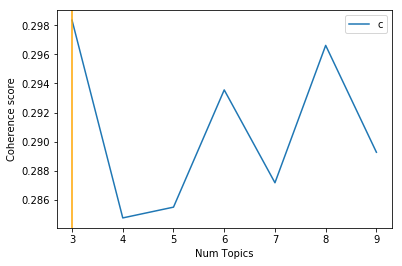

In [214]:
# Show graph
limit = 15
start = 3
step = 1
#  Find the index of the max value
max_idx = coherence_values.index(max(coherence_values))
# Sanity check
# coherence_values[19]
x = range(start, limit, step)
print(f'Max coherence: {max(coherence_values)}, Num Topics at max coherence: {x[max_idx]}')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=x[max_idx], color = 'orange')
plt.show()

In [215]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.2983
Num Topics = 4  has Coherence Value of 0.2848
Num Topics = 5  has Coherence Value of 0.2855
Num Topics = 6  has Coherence Value of 0.2936
Num Topics = 7  has Coherence Value of 0.2872
Num Topics = 8  has Coherence Value of 0.2966
Num Topics = 9  has Coherence Value of 0.2893


In [12]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"information" + 0.017*"service" + 0.016*"site" + 0.015*"personal" + '
  '0.012*"party" + 0.011*"website" + 0.009*"third" + 0.008*"provide" + '
  '0.008*"email" + 0.007*"user"'),
 (1,
  '0.044*"information" + 0.017*"site" + 0.012*"email" + 0.011*"service" + '
  '0.009*"website" + 0.009*"third" + 0.009*"personal" + 0.008*"address" + '
  '0.007*"collect" + 0.007*"party"'),
 (2,
  '0.060*"information" + 0.018*"site" + 0.016*"service" + 0.011*"user" + '
  '0.010*"website" + 0.010*"personal" + 0.009*"party" + 0.009*"cooky" + '
  '0.008*"collect" + 0.008*"address"'),
 (3,
  '0.063*"information" + 0.018*"site" + 0.015*"service" + 0.010*"party" + '
  '0.009*"third" + 0.009*"personal" + 0.009*"provide" + 0.009*"user" + '
  '0.008*"collect" + 0.008*"website"'),
 (4,
  '0.047*"information" + 0.016*"site" + 0.014*"service" + 0.012*"email" + '
  '0.009*"personal" + 0.008*"address" + 0.008*"provide" + 0.007*"third" + '
  '0.007*"cooky" + 0.007*"user"'),
 (5,
  '0.036*"information" + 0.0

In [16]:
# Save model to disk.
temp_file = datapath("./optimal_LDA_model")
optimal_model.save(temp_file)

# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)


In [121]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 20, sort_topics = True)
vis

/anaconda3/envs/insight_s19/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003743  0.003617       1        1  33.256729
0     -0.007952 -0.005445       2        1  27.180973
3     -0.002603  0.005901       3        1  19.232113
4      0.004291 -0.003787       4        1   9.162796
1      0.006109  0.001341       5        1   5.735761
5      0.003899 -0.001627       6        1   5.431625, topic_info=     Category          Freq            Term         Total  loglift  logprob
366   Default  15605.000000     information  15605.000000  15.0000  15.0000
679   Default   4961.000000            site   4961.000000  14.0000  14.0000
250   Default   2461.000000           email   2461.000000  13.0000  13.0000
668   Default   4416.000000         service   4416.000000  12.0000  12.0000
744   Default   2463.000000           third   2463.000000  11.0000  11.0000
807   Default   2707.000000         website   2707.000000  10.0000  10.0000
170   Default   2128.000000           cooky   2128.000000   9.0000   9.0000
19    Default   2019.000000         address   2019.000000   8.0000   8.0000
507   Default   2744.000000           party   2744.000000   7.0000   7.0000
515   Default   3106.000000        personal   3106.000000   6.0000   6.0000
778   Default   2478.000000            user   2478.000000   5.0000   5.0000
45    Default   1501.000000            also   1501.000000   4.0000   4.0000
187   Default   1357.000000            data   1357.000000   3.0000   3.0000
3     Default   1520.000000          access   1520.000000   2.0000   2.0000
745   Default   1571.000000            time   1571.000000   1.0000   1.0000
7515   Topic1      4.918143       gardening      7.228209   0.7159  -9.8643
2689   Topic1     10.624146           gmail     17.329157   0.6117  -9.0941
7506   Topic1      3.082403         analyse      5.055036   0.6062 -10.3315
1048   Topic1      3.067410      visibility      5.069193   0.5986 -10.3364
1008   Topic1      3.028182          sensor      5.033173   0.5928 -10.3492
984    Topic1      3.043672         quicker      5.062140   0.5922 -10.3441
7525   Topic1      1.790905         onesfor      3.001307   0.5846 -10.8745
7504   Topic1      1.771318   accelerometer      2.976002   0.5821 -10.8855
3947   Topic1      4.219400          geotag      7.113365   0.5786 -10.0175
4675   Topic1      6.541561  restaurantnews     11.083858   0.5736  -9.5790
7508   Topic1      1.746783    autocomplete      3.003711   0.5588 -10.8994
4313   Topic1     20.331852         mohegan     35.102970   0.5548  -8.4450
7530   Topic1      1.718377      protectfor      2.971174   0.5533 -10.9158
3750   Topic1      6.495924        affinity     11.241144   0.5525  -9.5860
7520   Topic1      1.719190            lbcs      2.987564   0.5483 -10.9154
...       ...           ...             ...           ...      ...      ...
3814   Topic6      0.417225        onepixel      2.601668   1.0827 -10.5193
3806   Topic6      0.409294      engagement      2.587301   1.0690 -10.5385
4335   Topic6      0.989136  privacyscinews      6.315728   1.0590  -9.6561
6950   Topic6      0.264893  cookiesscinews      1.730729   1.0360 -10.9736
3810   Topic6      0.534677            hind      3.514826   1.0298 -10.2713
2976   Topic6     13.590807           sport     92.051636   1.0000  -7.0358
4579   Topic6      8.877131           kinja     60.921738   0.9868  -7.4617
7003   Topic6      1.393562            echo      9.462638   0.9974  -9.3133
3707   Topic6      6.265298            nara     47.268364   0.8921  -7.8102
1943   Topic6      9.551645           zacks     77.087807   0.8247  -7.3885
250    Topic6    220.263779           email   2461.221680   0.4993  -4.2504
3354   Topic6      5.392355   washingtonian     43.216255   0.8317  -7.9602
187    Topic6    102.905510            data   1357.524292   0.3333  -5.0114
679    Topic6    307.479431            site   4961.309570   0.1319  -3.9168
170    Topic6    144.486877  

In [15]:
# Save visualization
pyLDAvis.save_html(vis, 'pp_pylda_vis.html')

In [17]:
# Visualize the topics with tsne transformation
pyLDAvis.enable_notebook()
vis_tsne = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds = 'tsne',R = 20, sort_topics = True)
vis_tsne

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      15.046137   7.186164       1        1  33.274483
0       9.724442  13.850856       2        1  27.102100
3       1.905665   2.359922       3        1  19.214546
4       1.679781  11.019171       4        1   9.172740
1       7.714116   6.943252       5        1   5.801170
5      10.264927   0.010398       6        1   5.434951, topic_info=    Category          Freq          Term         Total  loglift  logprob
366  Default  15602.000000   information  15602.000000  30.0000  30.0000
679  Default   4961.000000          site   4961.000000  29.0000  29.0000
250  Default   2462.000000         email   2462.000000  28.0000  28.0000
668  Default   4415.000000       service   4415.000000  27.0000  27.0000
744  Default   2463.000000         third   2463.000000  26.0000  26.0000
807  Default   2707.000000       website   2707.000000  25.0000  25.0000
170  Default   2128.000000         cooky   2128.000000  24.0000  24.0000
19   Default   2020.000000       address   2020.000000  23.0000  23.0000
507  Default   2742.000000         party   2742.000000  22.0000  22.0000
515  Default   3105.000000      personal   3105.000000  21.0000  21.0000
778  Default   2478.000000          user   2478.000000  20.0000  20.0000
45   Default   1502.000000          also   1502.000000  19.0000  19.0000
187  Default   1357.000000          data   1357.000000  18.0000  18.0000
3    Default   1520.000000        access   1520.000000  17.0000  17.0000
745  Default   1571.000000          time   1571.000000  16.0000  16.0000
563  Default   2311.000000       provide   2311.000000  15.0000  15.0000
127  Default   2135.000000       collect   2135.000000  14.0000  14.0000
969  Default   1084.000000    personally   1084.000000  13.0000  13.0000
551  Default   1173.000000       product   1173.000000  12.0000  12.0000
157  Default   1298.000000       contact   1298.000000  11.0000  11.0000
927  Default   1096.000000  identifiable   1096.000000  10.0000  10.0000
160  Default   1345.000000       content   1345.000000   9.0000   9.0000
571  Default   1095.000000       purpose   1095.000000   8.0000   8.0000
30   Default   1233.000000   advertising   1233.000000   7.0000   7.0000
617  Default   1142.000000       request   1142.000000   6.0000   6.0000
479  Default   1456.000000        online   1456.000000   5.0000   5.0000
498  Default   1000.000000          page   1000.000000   4.0000   4.0000
642  Default    932.000000         right    932.000000   3.0000   3.0000
459  Default    954.000000          name    954.000000   2.0000   2.0000
6    Default   1496.000000       account   1496.000000   1.0000   1.0000
..       ...           ...           ...           ...      ...      ...
969   Topic6     74.687340    personally   1084.169556   0.2371  -5.3325
668   Topic6    239.931747       service   4415.570801  -0.0002  -4.1654
445   Topic6     45.681866       message    613.859985   0.3143  -5.8241
507   Topic6    156.540329         party   2742.952148   0.0488  -4.5925
927   Topic6     72.368874  identifiable   1096.233643   0.1945  -5.3640
759   Topic6     39.697529          type    533.092163   0.3149  -5.9645
778   Topic6    137.938477          user   2478.187012   0.0238  -4.7190
744   Topic6    136.718033         third   2463.687256   0.0208  -4.7279
807   Topic6    146.422226       website   2707.598145  -0.0050  -4.6593
30    Topic6     77.296753   advertising   1233.534912   0.1423  -5.2981
745   Topic6     92.286110          time   1571.523071   0.0774  -5.1209
366   Topic6    549.837463   information  15602.939453  -0.4333  -3.3362
498   Topic6     64.177864          page   1000.467957   0.1658  -5.4841
781   Topic6     55.866322         using    844.916748   0.1960  -5.6228
157   Topic6     76.067062       contact   1298.752075   0.0748  -5.3142
19    Topic6    104.762650       address   2020.407349  -0.0470  -4.9941
45   

In [51]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=split_data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [52]:
optimal_model.show_topics(formatted=True, num_words=10)

[(0,
  '0.052*"information" + 0.017*"service" + 0.016*"site" + 0.015*"personal" + 0.012*"party" + 0.011*"website" + 0.009*"third" + 0.008*"provide" + 0.008*"email" + 0.007*"user"'),
 (1,
  '0.044*"information" + 0.017*"site" + 0.012*"email" + 0.011*"service" + 0.009*"website" + 0.009*"third" + 0.009*"personal" + 0.008*"address" + 0.007*"collect" + 0.007*"party"'),
 (2,
  '0.060*"information" + 0.018*"site" + 0.016*"service" + 0.011*"user" + 0.010*"website" + 0.010*"personal" + 0.009*"party" + 0.009*"cooky" + 0.008*"collect" + 0.008*"address"'),
 (3,
  '0.063*"information" + 0.018*"site" + 0.015*"service" + 0.010*"party" + 0.009*"third" + 0.009*"personal" + 0.009*"provide" + 0.009*"user" + 0.008*"collect" + 0.008*"website"'),
 (4,
  '0.047*"information" + 0.016*"site" + 0.014*"service" + 0.012*"email" + 0.009*"personal" + 0.008*"address" + 0.008*"provide" + 0.007*"third" + 0.007*"cooky" + 0.007*"user"'),
 (5,
  '0.036*"information" + 0.020*"site" + 0.016*"service" + 0.014*"email" + 0.01

In [53]:
df_dominant_topic.head(2)
# merge topic info with main df
df_with_topic = pd.concat([df, df_dominant_topic], axis = 1)
df_with_topic.head(5)

,doc_type,file,text,year,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy Last Modified March 25 2013 Thi...,2013,0,2.0,0.3610,"information, site, service, user, website, per...","[last, modified, march, latinpost, site, inten..."
1,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Welcome to the Google Privacy Policy When you...,2015,1,2.0,0.9922,"information, site, service, user, website, per...","[welcome, google, google, service, trust, info..."
2,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Web Privacy Statement Austin Community Colleg...,,2,3.0,0.9234,"information, site, service, party, third, pers...","[statement, austin, community, college, commit..."
3,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy PBS is committed to protecting ...,2009,3,5.0,0.4420,"information, site, service, email, party, webs...","[committed, protecting, private, information, ..."
4,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Security and Accessibility Policies US...,,4,2.0,0.7785,"information, site, service, user, website, per...","[security, accessibility, policy, doesnt, coll..."


### Summarize by topic

In [55]:
# Get the top n documents for each topic
tmp = df_with_topic.groupby('Dominant_Topic')

# dfs = []
# # top_n = 3

# for group, _df in tmp:
#     indices = _df['Topic_Perc_Contrib'].sort_values(ascending=False)
#     _df = _df[_df['Topic_Perc_Contrib'].isin(indices[:])].sort_values('Topic_Perc_Contrib', ascending=False)
#     dfs.append(_df)

# dfs = pd.concat(dfs, axis=0)

summary_stories = []

for group, _df in tmp:  
#     display(' '.join(_df['story']))
    summary = summarize(' '.join(_df['text']), ratio = .05, split = True)   
    summary_stories.append({'Dominant Topic':group, 'Summary':summary})


# df_with_topic = dfs.join(df.set_index('Document_No'), on='Document_No')
# df_with_topic.head(5)

KeyboardInterrupt: 

In [ ]:
summary_df = pd.DataFrame(summary_stories).head(2)

## Apply saved model to new data

In [96]:
%%time
# Clean, lemmatize, and tokenize text
url = 'https://machinebox.io/privacy'
new_co_name = list(url.split('/')[2])
new_pp = get_new_pp(url = url)
new_pp_words = tokenize(pd.Series(new_pp), stop_words=stop_words,
                      frequent_words=(frequent_words+new_co_name))
# print(len(new_pp_words))
print(f'Number of words in the new document: {len(new_pp_words[0])}')

Number of words in the new document: 443
CPU times: user 43.2 ms, sys: 2.23 ms, total: 45.5 ms
Wall time: 470 ms


In [117]:
# Convert pd series to flattened list 
new_pp_words = sum(new_pp_words.tolist(), [])

In [116]:
new_doc_bow = id2word.doc2bow(new_pp_words)
print(new_doc_bow)
print(optimal_model.get_document_topics(new_doc_bow))

[(2, 1), (4, 2), (5, 1), (6, 7), (8, 1), (15, 1), (16, 1), (19, 4), (22, 1), (32, 1), (40, 1), (43, 1), (49, 1), (53, 1), (55, 1), (73, 1), (75, 2), (76, 1), (77, 1), (84, 1), (97, 3), (98, 2), (127, 4), (136, 1), (137, 4), (147, 1), (154, 2), (157, 1), (158, 2), (160, 2), (163, 1), (177, 4), (183, 2), (198, 1), (199, 1), (207, 2), (213, 1), (216, 2), (220, 3), (223, 2), (243, 1), (252, 2), (258, 1), (260, 1), (277, 1), (289, 1), (300, 2), (314, 1), (325, 1), (332, 1), (341, 1), (352, 2), (355, 1), (357, 5), (366, 31), (375, 1), (377, 1), (378, 1), (406, 2), (422, 1), (433, 3), (462, 3), (474, 2), (482, 1), (496, 2), (497, 3), (506, 2), (509, 5), (515, 18), (522, 1), (532, 1), (534, 2), (540, 3), (541, 1), (548, 1), (549, 4), (550, 3), (551, 1), (552, 1), (556, 1), (560, 2), (561, 2), (562, 1), (563, 8), (564, 1), (565, 4), (566, 1), (571, 5), (573, 1), (580, 3), (581, 1), (592, 3), (595, 1), (602, 1), (605, 1), (617, 5), (620, 1), (621, 1), (622, 1), (623, 1), (627, 1), (640, 1), (655

In [143]:
# Create a new corpus, made of previously unseen documents.

# other_corpus = [common_dictionary.doc2bow(text) for text in new_pp_words]
# other_corpus[0]
# unseen_doc = other_corpus[0]
vector = optimal_model[new_doc_bow]  # get topic probability distribution for a document
vector
# vector = lda[unseen_doc]  # get topic probability distribution for a document
# # Update the model by incrementally training on the new corpus

# optimal_model.update(new_doc_bow)
# vector = lda[unseen_doc]

[(0, 0.48909467), (2, 0.42385474), (3, 0.08577168)]

In [146]:
vector[0][0]
prob=0.3

In [148]:
def get_topics_4_new_docs(model=optimal_model, topics=vector, prob = .3):
    topic_keywords = [model.show_topics()[topic[0]] for topic in vector if topic[1] > prob]
    return topic_keywords

In [149]:
get_topics_4_new_docs(model = optimal_model, topics=vector)

[(0,
  '0.052*"information" + 0.017*"service" + 0.016*"site" + 0.015*"personal" + 0.012*"party" + 0.011*"website" + 0.009*"third" + 0.008*"provide" + 0.008*"email" + 0.007*"user"'),
 (2,
  '0.060*"information" + 0.018*"site" + 0.016*"service" + 0.011*"user" + 0.010*"website" + 0.010*"personal" + 0.009*"party" + 0.009*"cooky" + 0.008*"collect" + 0.008*"address"')]

In [ ]:
lda_index = similarities.MatrixSimilarity(lda_model[corpus])
 
# Let's perform some queries
similarities = lda_index[lda_model[bow]]
# Sort the similarities
similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
 
# Top most similar documents:
print(similarities[:10])
# [(104, 0.87591344), (178, 0.86124849), (31, 0.8604598), (77, 0.84932965), (85, 0.84843522), (135, 0.84421808), (215, 0.84184396), (353, 0.84038532), (254, 0.83498049), (13, 0.82832891)]
 
# Let's see what's the most similar document
document_id, similarity = similarities[0]
print(data[document_id][:1000])

## References
- https://radimrehurek.com/gensim/models/ldamodel.html
- https://nbviewer.jupyter.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Model%20Talk.ipynb
- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21